# Linear Regression

## Import libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, ElasticNetCV, ElasticNet
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split

# Data imputation
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

In [7]:
# Functions:

def simple_linear_regression(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=83)
    
    reg = LinearRegression(normalize=True).fit(X_train, y_train)

    y_pred = reg.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    ex_var = explained_variance_score(y_test, y_pred)
    
    return mae, r2, ex_var

def enet(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=83)

    reg = ElasticNet(normalize=False).fit(X_train, y_train)

    y_pred = reg.predict(X_test)
    
    return y_pred, y_test

def get_metrics(y_test, y_pred):
    
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    ex_var = explained_variance_score(y_test, y_pred)
    
    return mae, r2, ex_var

def feature_engineering(df):## Add month of the year

    print("1. Including month of the year from 'week_start_date....'")
    df['week_start_date'] = pd.to_datetime(df['week_start_date'])
    df['monthofyear'] = df['week_start_date'].apply(lambda x: x.month)


    # High correlation between ndvi_nw-ndvi-ne and ndvi-sw-ndvi-se
    # Add the mean of each pair that indicates the level of vegetation in the north and south of both cities.

    # Features engineering
    print("2. Including ndvi_north and  ndvi_south from ndvi_nw, ndvi_ne, ndvi_sw, ndvi_se.... ")
    df['ndvi_north'] = df[['ndvi_nw', 'ndvi_ne']].mean(axis=1)
    df['ndvi_south'] = df[['ndvi_sw', 'ndvi_se']].mean(axis=1)

    #Remove feature

    df = df.drop(['ndvi_sw', 'ndvi_nw', 'ndvi_ne', 'ndvi_se', 'week_start_date'], axis=1)

    # Conversion kelvin to celsius
    print("3. Temperature units conversion: kelvin to celsius from some features...")
    import pytemperature

    df['reanalysis_air_temp_c'] = pytemperature.k2c(df['reanalysis_air_temp_k'])
    df['reanalysis_dew_point_temp_c'] = pytemperature.k2c(df['reanalysis_dew_point_temp_k'])
    df['reanalysis_max_air_temp_c'] = pytemperature.k2c(df['reanalysis_max_air_temp_k'])
    df['reanalysis_min_air_temp_c'] = pytemperature.k2c(df['reanalysis_min_air_temp_k'])
    df['reanalysis_avg_temp_c'] = pytemperature.k2c(df['reanalysis_avg_temp_k'])
    df['reanalysis_tdtr_c'] = pytemperature.k2c(df['reanalysis_tdtr_k'])

    # Drop kelvin features

    print("4. Drop variables")      
    df = df.drop(['reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k', 
                  'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
                  'reanalysis_avg_temp_k', 'reanalysis_tdtr_k'], axis=1)
    
    return df

def scale_impute_dataset(df, features_lreg, label):
    
    train_label   = df[label]
    train_dataset = df[features_lreg]
    
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
    df_imputed = pd.DataFrame(imp.fit_transform(train_dataset))

    df_imputed.columns = train_dataset.columns
    df_imputed.index   = train_dataset.index

    scaler = StandardScaler().fit(df_imputed)
    train_dataset_scaled = pd.DataFrame(scaler.transform(df_imputed), 
                                        columns=df_imputed.columns)
    
    train_dataset_scaled = pd.concat([train_dataset_scaled, train_label], axis=1)
    return(train_dataset_scaled)


In [8]:
# Load dataset

features_train = pd.read_csv('dengue_features_train.csv')
labels_train   = pd.read_csv('dengue_labels_train.csv')

features_test = pd.read_csv('dengue_features_test.csv')

# Join train labes and features
input_train_dataset = features_train.merge(labels_train, 
                                           left_on = ['city', 'year', 'weekofyear'], 
                                           right_on = ['city', 'year', 'weekofyear'],
                                           how = 'inner')

In [9]:
# Feature engineering
input_train_dataset = feature_engineering(input_train_dataset)

label = 'total_cases'


1. Including month of the year from 'week_start_date....'
2. Including ndvi_north and  ndvi_south from ndvi_nw, ndvi_ne, ndvi_sw, ndvi_se.... 
3. Temperature units conversion: kelvin to celsius from some features...
4. Drop variables


In [10]:
input_train_dataset.head()

,city,year,weekofyear,precipitation_amt_mm,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,station_avg_temp_c,station_diur_temp_rng_c,...,total_cases,monthofyear,ndvi_north,ndvi_south,reanalysis_air_temp_c,reanalysis_dew_point_temp_c,reanalysis_max_air_temp_c,reanalysis_min_air_temp_c,reanalysis_avg_temp_c,reanalysis_tdtr_c
0,sj,1990,18,12.42,32.00,73.365714,12.42,14.012857,25.442857,6.900000,...,4,4,0.113162,0.188050,24.422857,19.264286,26.65,22.75,24.592857,-270.521429
1,sj,1990,19,22.82,17.94,77.368571,22.82,15.372857,26.714286,6.371429,...,5,5,0.156037,0.158921,25.061429,20.801429,27.75,23.25,25.292857,-270.778571
2,sj,1990,20,34.54,26.10,82.052857,34.54,16.848571,26.714286,6.485714,...,4,5,0.102608,0.164021,25.631429,22.284286,27.35,24.15,25.728571,-270.850000
3,sj,1990,21,15.36,13.90,80.337143,15.36,16.672857,27.471429,6.771429,...,3,5,0.186850,0.231721,25.837143,22.160000,28.25,23.85,26.078571,-270.721429
4,sj,1990,22,7.52,12.20,80.460000,7.52,17.210000,28.942857,9.371429,...,6,5,0.229200,0.249270,26.368571,22.671429,28.75,24.35,26.514286,-270.135714


## Data imputation + Simple linear regression

In [32]:
features_lreg = input_train_dataset.columns.drop(['city', 'total_cases'])

train_dataset_scaled = scale_impute_dataset(input_train_dataset, features_lreg, label)

y_pred, y_test = enet(train_dataset_scaled[features_lreg], train_dataset_scaled[label])

res = get_metrics(y_pred, y_test)

print(res)

(18.708313493680443, -5.18926082921255, -5.187273963583635)


In [36]:
# For each city

features_lreg = input_train_dataset.columns.drop(['city', 'total_cases'])

cities = input_train_dataset['city'].unique()

y_pred_final = list()
y_test_final = list()

for city in cities:
    print(city)
    
    print("Scaling data")
    
    train_dataset_city = input_train_dataset[input_train_dataset['city'] == city]
    
    train_dataset_scaled = scale_impute_dataset(train_dataset_city, features_lreg, label)
    
    print("Train and predict")
    y_pred, y_test = enet(train_dataset_scaled[features_lreg], train_dataset_scaled[label])
 
    y_pred_final = y_pred_final + list(y_pred)

    y_test_final = y_test_final + list(y_test)

res = get_metrics(y_pred_final, y_test_final)   
print(res)

sj
Scaling data
Train and predict
iq
Scaling data
Train and predict


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [40]:
# For each city

features_lreg = input_train_dataset.columns.drop(['city', 'total_cases'])

city = "sj"

print("Scaling data")

train_dataset_city = input_train_dataset[input_train_dataset['city']=="sj"]

features_lreg = train_dataset_city.columns.drop(['city', 'total_cases'])

train_dataset_scaled = scale_impute_dataset(train_dataset_city, features_lreg, label)

train_dataset_scaled.dropna().shape

Scaling data


(936, 22)

In [39]:
y_pred, y_test = enet(train_dataset_city[features_lreg], train_dataset_city[label])

res = get_metrics(y_pred, y_test)

print(res)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## PCA

https://georgemdallas.wordpress.com/2013/10/30/principal-component-analysis-4-dummies-eigenvectors-eigenvalues-and-dimension-reduction/
    

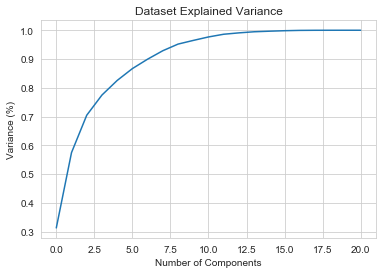

In [23]:
from sklearn.decomposition import PCA

pca = PCA()

principalComponents = pca.fit_transform(train_dataset_scaled[features_lreg])
principalDf = pd.DataFrame(data = principalComponents)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()

In [26]:
pca = PCA(n_components=12)
dataset_train = pca.fit_transform(train_dataset_scaled[features_lreg])
#dataset = pd.DataFrame(dataset, columns = ['pca_comp1', 'pca_comp2', 'pca_comp3', 'pca_comp4', 'pca_comp5'])
dataset_train.shape

(1456, 12)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(dataset_train, 
                                                    train_dataset_scaled[label], 
                                                    test_size = 0.2, 
                                                    random_state=83)

reg = ElasticNet(normalize=False).fit(X_train, y_train)

y_pred = reg.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
ex_var = explained_variance_score(y_test, y_pred)

print(mae)
print(r2)
print(ex_var)

18.773843868225754
0.17538325891703155
0.1755627674957434
